# Genetic Algorithm-Driven Feature Selection for Skin Cancer Classification
### Research Overview
This project presents an evolutionary approach to optimizing image classification for skin cancer (benign vs. malignant). While Convolutional Neural Networks (CNNs) are powerful for feature extraction, achieving optimal performance often requires refining the feature space to avoid the "Curse of Dimensionality".

### Key Objectives


Feature Extraction: Utilize a pre-trained VGG-16 model to extract high-dimensional features from skin lesion images.


Dimensionality Reduction: Apply Principal Component Analysis (PCA) to condense the feature space.


Evolutionary Optimization: Implement a Genetic Algorithm (GA) to select the most informative subset of features, maximizing accuracy while minimizing computational complexity.

Published Paper link: https://link.springer.com/chapter/10.1007/978-981-96-5958-6_22

## Imports and Data Loading

In [2]:
import os
import glob
import cv2
import deap
from deap import base, creator, tools, algorithms
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn import preprocessing
import pickle
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SIZE = 190

In [ ]:
train_images = []
train_labels = []

We will load the augmented data that we generated in the data augmentation notebook

In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/SkinDisease/data/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

benign
/content/drive/MyDrive/SkinDisease/data/train/benign/1504.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1497.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1518.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1507.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1522.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1500.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1520.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1517.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1512.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1505.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1523.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1511.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/152.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1508.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1510.jpg
/content/drive/MyDrive/SkinDisease/data/train/benign/1513.jpg
/c

In [ ]:
# capturing test/validation data and labels into respective lists

test_images = []
test_labels = []
for directory_path in glob.glob("/content/drive/MyDrive/SkinDisease/data/test/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

# converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
print(test_labels)

['malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'malignant' 'malignant'
 'malignant' 'malignant' 'malignant' 'malignant' 'm

## Data Preprocessing

In [ ]:
# encoding labels from text to integers.

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
print(train_labels_encoded)

[0 0 0 ... 1 1 1]


In [ ]:
# splitting data into train and test datasets
x_train, y_train = train_images, train_labels_encoded
x_test, y_test = test_images, test_labels_encoded

In [ ]:

# normalizing pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

##  Pre-trained VGG-16 to Extract Image Features

Images are processed through 13 convolutional layers. Features are extracted from the final pooling layer, resulting in a $(7 \times 7 \times 512)$ feature map.

In [ ]:
VGG_Model = VGG16(include_top=False, weights= 'imagenet', input_shape=(SIZE,SIZE,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

for layer in VGG_Model.layers:
	layer.trainable = False

VGG_Model.summary()  # trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# now, let us use features from convolutional network for Random Forest (RF)
feature_extractor=VGG_Model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features # our x input to RF

83/83 [==============================] - 1512s 18s/step


In [ ]:
# sending test data through same feature extractor process
X_test_feature = VGG_Model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

21/21 [==============================] - 375s 18s/step


## PCA Initial Reduction to choose 100 features
High-dimensional data is projected onto principal components to retain maximum variance while reducing noise.

In [ ]:

pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(X_for_RF)
test_features_pca = pca.transform(X_test_features)

In [ ]:
# classification through Random Forest

RF_model = RandomForestClassifier(max_depth=10)

In [ ]:
RF_model.fit(train_features_pca, y_train)

RandomForestClassifier(max_depth=10)

In [ ]:
prediction_RF = RF_model.predict(test_features_pca)

In [ ]:

print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

Accuracy =  0.8409090909090909


In [ ]:
# results of initial RF clasification

prediction_RF2 = le.inverse_transform(prediction_RF)
print(classification_report(test_labels, prediction_RF2))

              precision    recall  f1-score   support

      benign       0.89      0.80      0.85       360
   malignant       0.79      0.89      0.84       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.85      0.84      0.84       660



In [ ]:
print(X_for_RF.shape)
print(X_test_features.shape)

(2651, 25088)
(660, 25088)


## Data Persistance
Saving the features extracted as well as the classified lables for future use for when we optimize it using Genetic Algorithm

In [ ]:
data_to_save = {
    'X_for_RF': X_for_RF,
    'X_test_features': X_test_features,
    'y_train': y_train,
    'y_test': y_test,
    'test_labels': test_labels,
    'train_labels': train_labels
}

In [ ]:
file_path = '/content/drive/MyDrive/SkinDisease/ga_data(RF).pkl'
with open(file_path, 'wb') as f:
    pickle.dump(data_to_save, f)

In [ ]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

## Preparing data for Genetic Algorithm Optimization (GA)
The Genetic Algorithm treats feature subsets as "chromosomes." Through generations of selection, crossover, and mutation, it identifies the "fittest" features that lead to the highest classification accuracy.

In [ ]:

X_for_RF = loaded_data['X_for_RF']
X_test_features = loaded_data['X_test_features']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
train_labels = loaded_data['train_labels']
test_labels = loaded_data['test_labels']

PCA Feature Selection

In [ ]:
# applying PCA initially
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(X_for_RF)
test_features_pca = pca.transform(X_test_features)

Genetic Algorithm

In [ ]:
# second random forest model
RF_model2 = RandomForestClassifier(max_depth=10)

## GA Feature Selection
The Genetic Algorithm treats feature subsets as "chromosomes." Through generations of selection, crossover, and mutation, it identifies the "fittest" features that lead to the highest classification accuracy.

In [ ]:
N_FEATURES = train_features_pca.shape[1]
POP_SIZE = 100  # population size
N_GEN = 30  # number of generations
CX_PB = 0.7  # crossover probability
MUT_PB = 0.3  # mutation probability

In [ ]:

def evaluate(individual):
    selected_features = [index for index in range(len(individual)) if individual[index] == 1]
    if len(selected_features) == 0:
        return 0, len(individual)  # heavily penalize empty feature sets


    X_train_selected = train_features_pca[:, selected_features]
    X_test_selected = test_features_pca[:, selected_features]


    RF_model2.fit(X_train_selected, y_train)
    P_test = RF_model2.predict(X_test_selected)
    prediction_RF = le.inverse_transform(P_test)

    # evaluate on validation set
    accuracy = accuracy_score(test_labels, prediction_RF)

    # multi-objective fitness: maximize accuracy while minimizing features
    return accuracy, -len(selected_features)

In [ ]:
# defining individual and population
import random
if 'FitnessMax' in dir(creator):
    del creator.FitnessMax
if 'Individual' in dir(creator):
    del creator.Individual

# DEAP setup
creator.create("FitnessMax", base.Fitness, weights=(1.0, -0.1))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)

## Classification
Optimized features are fed into a Random Forest (RF) classifier for final diagnosis.

gen	nevals	avg     	std    	min	max 
0  	100   	-24.4655	25.5185	-71	0.85
1  	76    	-24.4606	25.5791	-69	0.851515
2  	91    	-24.4656	25.5718	-67	0.851515
3  	68    	-24.4316	25.5497	-66	0.854545
4  	84    	-24.3513	25.4648	-64	0.851515
5  	78    	-24.3915	25.5051	-64	0.856061
6  	87    	-24.4018	25.5188	-65	0.856061
7  	87    	-24.3822	25.5191	-70	0.85303 
8  	87    	-24.3874	25.5893	-70	0.85303 
9  	73    	-24.4077	25.645 	-70	0.856061
10 	81    	-24.3918	25.6123	-64	0.85    
Best individual: [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
Selected features: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 22, 23, 25, 26, 27, 29, 30, 31, 32, 34, 37, 38, 40, 42, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61, 63, 65, 66

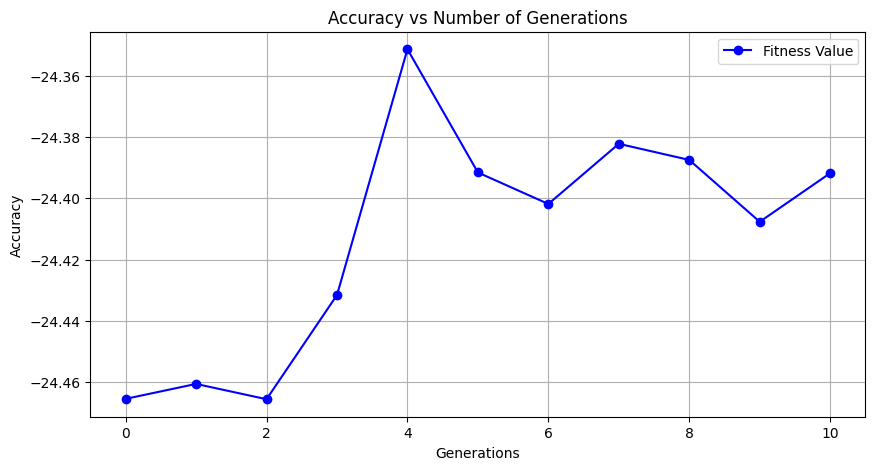

Classification Report:
               precision    recall  f1-score   support

      benign       0.89      0.81      0.85       360
   malignant       0.79      0.88      0.83       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



In [ ]:
# running the Genetic Algorithm
le = LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

def main():
    population = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, logbook = algorithms.eaSimple(population, toolbox, cxpb=CX_PB, mutpb=MUT_PB, ngen=N_GEN,
                                              stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]
    best_accuracy = hof[0].fitness.values[0]
    best_features = [index for index in range(len(best_individual)) if best_individual[index] == 1]

    return population, stats, hof, best_individual, best_accuracy, best_features, logbook

if __name__ == "__main__":
    population, stats, hof, best_individual, best_accuracy, best_features, logbook = main()
    print("Best individual:", best_individual)
    print("Selected features:", best_features)
    print("Best cross-validated accuracy:", best_accuracy)
    print("best number of features:", len(best_features))

    # accuracy per generation for plotting
    gen = logbook.select("gen")
    avg_acc = logbook.select("avg")


    plt.figure(figsize=(10, 5))
    plt.plot(gen, avg_acc, marker='o', linestyle='-', color='b', label='Fitness Value')
    plt.xlabel('Generations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # evaluate the best individual on test set
    best_test_features = test_features_pca[:, best_features]

    RF_model2.fit(train_features_pca[:, best_features], y_train)


    y_test_pred = RF_model2.predict(best_test_features)
    y_test_pred_labels = le.inverse_transform(y_test_pred)

    # classification report
    class_report = classification_report(test_labels, y_test_pred_labels, target_names=le.classes_)
    print("Classification Report:\n", class_report)


## Results and Conclusion
The study compared standard PCA-reduced features against the GA-driven PCA features. The empirical findings confirmed that:


Accuracy Lift: GA-driven feature selection significantly outperformed standard PCA across the Random Forest classifier.


Efficiency: The model achieved higher classification accuracy using a minimum number of features, proving that quality of data is more critical than quantity.


Ensemble Superiority: The Random Forest ensemble classifier showed high robustness in distinguishing between benign and malignant cases when paired with the evolutionary feature set.


## Impact

This methodology provides a computationally efficient and highly accurate framework for medical diagnosis, potentially assisting dermatologists in early-stage skin cancer detection.